# Modeling Notebook

This notebook implements and compares **four classification models** to predict movie genres from poster images, using our consolidated (reduced) genre labels.

## Feature Extracted in the previous notebook

- **Classic descriptors**:  
  - HSV color histograms  
  - Histogram of Oriented Gradients (HOG)  
- **Deep embeddings**:  
  - ResNet50 (pre-trained CNN)  
  - Vision Transformer (ViT)  

## Models Overview

We train and evaluate:

1. **Support Vector Machine (SVM)** on the extracted feature vectors  
2. **Logistic Regression** on the extracted feature vectors  
3. **Zero‑shot CLIP** using cosine similarity between image and text embeddings  
4. **Fine‑tuned ResNet50** CNN classifier  

## Evaluation Workflow

1. **Data Balancing** by performing random undersampling to equalize class frequencies by reducing each majority class down to the size of the smallest class.  
2. **Data Split** the balanced dataset into stratified train, validation, and test sets.
3. **Preprocessing**  
   - Feature scaling & PCA (for SVM / LR)  
   - Image resizing with padding (for CNNs)  
4. **Hyperparameter tuning** via cross‑validation (GridSearchCV / early stopping)  
5. **Performance metrics**  
   - Accuracy scores  
   - Confusion matrices  
   - Classification reports  
6. **Model comparison** and error analysis (misclassified examples)  

### **1.1 Improt necessary libraries**

In [2]:
# --- System and Utility ---
import os
import re
import pickle
import ast

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Processing ---
import cv2
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Machine Learning: Scikit-learn ---
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# --- Deep Learning: TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- Deep Learning: PyTorch and CLIP ---
import torch
import clip

# --- Model Wrapping and Caching ---
from scikeras.wrappers import KerasClassifier
from joblib import Memory


In [4]:
import warnings
warnings.filterwarnings('ignore')

### **1.2 Load extracted feature datasets for poster classification**

In [30]:
# ======== HSV Features ========
# Read the pickle containing HSV histograms and moments
hsv_df = pd.read_pickle("Features/classic_hsv_features_named.pkl")
hsv_df = pd.DataFrame(hsv_df)

# Expand the 'features' dict column into separate columns
features_df = hsv_df['features'].apply(pd.Series)
hsv_feature = pd.concat([hsv_df.drop(columns=['features']), features_df], axis=1)

# Flatten label lists/arrays to strings
hsv_feature['labels'] = hsv_feature['labels'].apply(
    lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x)
)

# Split the concatenated HSV histogram into its three channels
hsv_feature['hue_hist']        = hsv_feature['hsv_histogram'].apply(lambda x: x[:32])
hsv_feature['saturation_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[32:64])
hsv_feature['value_hist']      = hsv_feature['hsv_histogram'].apply(lambda x: x[64:])

# Stack the full HSV histogram vectors into a matrix for modeling
hsv_matrix = np.stack(hsv_feature['hsv_histogram'].values)
hsv_labels = hsv_feature['labels'].values

# Encode string labels into integer indices
label_encoder  = LabelEncoder()
encoded_labels = label_encoder.fit_transform(hsv_feature['labels'])

# ======== HOG Features ========
# Read the pickle containing HOG feature vectors
hog_df = pd.read_pickle("Features/classic_hog_features.pkl")
hog_df = pd.DataFrame(hog_df)

# Flatten the label column and stack feature vectors
hog_df['labels'] = hog_df['labels'].apply(
    lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x)
)
hog_matrix = np.stack(hog_df['features'].values)
hog_labels = hog_df['labels'].values

# ======== ResNet50 Features ========
# Read the pickle containing ResNet50 embeddings
resnet_df = pd.read_pickle("Features/resnet_features.pkl")
resnet_df = pd.DataFrame(resnet_df)

# Stack the 2048-dimensional ResNet feature vectors
resnet_matrix = np.stack(resnet_df['features'].values)
resnet_labels = resnet_df['label'].values

# ======== Vision Transformer (ViT) Features ========
# Read the pickle containing ViT embeddings
vit_df = pd.read_pickle("Features/vit_features.pkl")
vit_df = pd.DataFrame(vit_df)

# Flatten any list labels and stack the 768-dimensional ViT vectors
vit_df['label'] = vit_df['label'].apply(
    lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x)
)
vit_matrix = np.stack(vit_df['features'].values)
vit_labels = vit_df['label'].values  # final array of string labels

In [31]:
original_labels = label_encoder.classes_
original_labels

array(['Action/Adventure', 'Comedy/Romance', 'Drama',
       'Historical/Biography', 'Music/Musical', 'Sci-Fi/Fantasy',
       'Sport/News', 'Suspense', 'War/Crime', 'Western/Family'],
      dtype=object)

### **1.3 Helper Functions**

In [34]:
def plot_confusion_matrix(conf_mat, title, labels, figname):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    sns.heatmap(
        conf_mat,
        annot=True, fmt='d',
        cmap='WhiteToOttanio',
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=3,
        # linecolor='white',
        square=True,
        annot_kws={"fontsize": 14, 
                   "fontweight": "semibold",
                   "color": "#414142"
                  },
        ax=ax
    )
    
    # Move x‑ticks to bottom
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    # # Move y‑ticks and label to right
    # ax.yaxis.set_ticks_position('right')
    # ax.yaxis.set_label_position('right')
    # ax.yaxis.tick_right()
    
    # Rotate and right‑align x‑tick labels
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )

    # Rotate y‑tick labels for better readability if needed
    plt.setp(
        ax.get_yticklabels(),
        rotation=0,
        va='bottom'
    )
    
    # Y‑ticks on the left (default)
    ax.tick_params(axis='y', rotation=0)
    
    # ax.set_title(title, fontsize=16, fontweight='bold', pad=12)
    ax.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
    ax.set_ylabel('True Label', fontsize=12, labelpad=10)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig("Plots/"+figname+"CM.png", dpi=300, transparent=True)
    plt.tight_layout()
    plt.show()

In [8]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Define the start and end hex colors
start_color = "#E8F8F9"
end_color = "#00AFB9"

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("cyan_to_orange", [start_color, end_color])

# Optional: register it globally (so you can use it by name later)
plt.colormaps.register(name="WhiteToOttanio", cmap=custom_cmap)

In [7]:
hog_df.labels.value_counts()

labels
Drama                   10803
Comedy/Romance           4920
Historical/Biography     3371
Suspense                 2533
Action/Adventure         2334
Music/Musical            1747
War/Crime                1371
Sport/News                836
Sci-Fi/Fantasy            730
Western/Family            620
Name: count, dtype: int64

## **2. Modeling**

In [8]:
# Prepare the different feature combinations.
features_dict = {
    "HSV": hsv_matrix,
    "HOG": hog_matrix,
    "ResNet50": resnet_matrix,
    "ViT": vit_matrix,
    "HOG+HSV": np.concatenate([hog_matrix, hsv_matrix], axis=1),
    "ResNet50+HOG": np.concatenate([resnet_matrix, hog_matrix], axis=1),
    "ViT+HSV": np.concatenate([vit_matrix, hsv_matrix], axis=1),
    "ResNet50+ViT": np.concatenate([resnet_matrix, vit_matrix], axis=1)
}

### **2.1 SVM Pipeline**

In [ ]:
best_score = -np.inf
best_result_svm = None

# List to record results from all feature combinations
results_svm = []

In [ ]:
# Hyperparameter grid for SVC: two grids for linear and RBF kernels.
param_grid = [
#     {'svm__kernel': ['rbf', 'poly', 'sigmoid'], 'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 'auto', 0.1, 1]},
    {'svm__kernel': ['rbf', 'poly', 'sigmoid'],    'svm__C': [0.1, 1, 10], 'svm__gamma': ['scale', 'auto', 0.1]}
]

In [ ]:
# Stratified 5-fold for GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Loop over each feature combination:
for combo_name, X_features in features_dict.items():
    print(f"\nProcessing feature combination: {combo_name}")

    # Set X to the current combination and y to labels
    X = X_features
    y = encoded_labels

    # Split the data with stratification (80% train, 20% validation)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    print(f"Original training set shape: {X_train.shape}, {y_train.shape}")

    # Combine X and y into a single DataFrame for easier manipulation
    train_df = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name='label')], axis=1)

    # Get the minimum class size
    min_class_size = train_df['label'].value_counts().min()
    print(f"Downsampling all classes to: {min_class_size} samples")

    # Downsample each class
    balanced_df = (
        train_df.groupby('label')
        .sample(n=min_class_size, random_state=42)
        .reset_index(drop=True)
    )

    # Split back into X and y
    X_train_bal = balanced_df.drop('label', axis=1).values
    y_train_bal = balanced_df['label'].values

    print(f"Balanced training set shape: {X_train_bal.shape}, {y_train_bal.shape}")


    # Build a pipeline: scaling, PCA (retain 95% variance), then SVM.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # can also be an int if you wish
        ('svm', SVC(class_weight='balanced', random_state=42))
    ])

    # Perform GridSearchCV to tune the SVM parameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_bal, y_train_bal)

    # Get best cross-validation score and parameters
    val_score = grid_search.best_score_
    print(f"  Best CV Score (Validation): {val_score:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

    # Evaluate training performance
    train_score = grid_search.score(X_train_bal, y_train_bal)
    print(f"  Training Score: {train_score:.4f}")

    # Evaluate the best estimator on the held-out test set
    test_score = grid_search.score(X_test, y_test)
    print(f"  Test Score: {test_score:.4f}")


    # save confusion matrices for analysis
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train_bal)
    y_pred_test = best_model.predict(X_test)


    cm_train = confusion_matrix(y_train_bal, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Classification report
    cr_train = classification_report(y_train_bal, y_pred_train, digits=2)
    cr_test = classification_report(y_test, y_pred_test, digits=2)

    result = {
        'combination': combo_name,
        'val_score': val_score,
        'train_score': train_score,
        'test_score': test_score,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'conf_matrix_train': cm_train,
        'conf_matrix_test': cm_test,
        'report_train': cr_train,
        'report_test': cr_test
    }

    # Record all results in a list
    results_svm.append(result)

    # Update the best model if the current validation score is higher than the best so far
    if val_score > best_score:
        best_result_svm = result
        best_score = val_score



Processing feature combination: HSV
Original training set shape: (23412, 96), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 96), (4960,)
  Best CV Score (Validation): 0.1679
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.4151
  Test Score: 0.1551

Processing feature combination: HOG
Original training set shape: (23412, 3600), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 3600), (4960,)


/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Best CV Score (Validation): 0.1466
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.8272
  Test Score: 0.1298

Processing feature combination: ResNet50
Original training set shape: (23412, 2048), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 2048), (4960,)
  Best CV Score (Validation): 0.2601
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.7837
  Test Score: 0.2324

Processing feature combination: ViT
Original training set shape: (23412, 768), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 768), (4960,)
  Best CV Score (Validation): 0.3040
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
  Training Score: 0.9054
  Test Score: 0.2624

Processing feature combination: HOG+HSV
Original training set shape: (23412, 3696), (23412,)
Downsampling all classes to: 496 samples
Balanced trainin

/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Best CV Score (Validation): 0.1613
  Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 1.0000
  Test Score: 0.1452

Processing feature combination: ResNet50+HOG
Original training set shape: (23412, 5648), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 5648), (4960,)
  Best CV Score (Validation): 0.2476
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.9040
  Test Score: 0.2110

Processing feature combination: ViT+HSV
Original training set shape: (23412, 864), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 864), (4960,)
  Best CV Score (Validation): 0.3042
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.8063
  Test Score: 0.2570

Processing feature combination: ResNet50+ViT
Original training set shape: (23412, 2816), (23412,)
Downsampling all classes to: 496 samples
B

/Users/richardlumpi/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Best CV Score (Validation): 0.2942
  Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
  Training Score: 0.8222
  Test Score: 0.2564


### 2.1.1 Save the SVM model

In [ ]:
# Save the best SVM model

with open("Features/best_svm_model.pkl", "wb") as f:
    pickle.dump(best_result_svm, f)

print("\nBest SVM model details saved to 'best_svm_model.pkl'")


Best SVM model details saved to 'best_svm_model.pkl'


### 2.1.2 Load the model

In [10]:
# Open the pickle file in read-binary mode
with open("Models/best_svm_model.pkl", "rb") as f:
    best_model_details_svm = pickle.load(f)

# Extract the best estimator from the loaded dictionary
best_model_svm = best_model_details_svm['best_estimator']

In [12]:
# Print some details about the loaded model
print("\n===== Best SVM Model Overall =====")
print(f"Best Combination: {best_model_details_svm['combination']}")
print(f"Training Score: {best_model_details_svm['train_score']:.4f}")
print(f"Validation Score: {best_model_details_svm['val_score']:.4f}")
print(f"Test Score: {best_model_details_svm['test_score']:.4f}")
print(f"Best Parameters: {best_model_details_svm['best_params']}")


===== Best SVM Model Overall =====
Best Combination: ViT+HSV
Training Score: 0.8063
Validation Score: 0.3042
Test Score: 0.2570
Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [70]:
# Print classification reports
print("\n===== Classification Report (Train) =====")
print(best_model_details_svm['report_train'])

print("\n===== Classification Report (Test) =====")
print(best_model_details_svm['report_test'])


===== Classification Report (Train) =====
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       496
           1       0.77      0.82      0.79       496
           2       0.81      0.77      0.79       496
           3       0.84      0.82      0.83       496
           4       0.85      0.81      0.83       496
           5       0.81      0.78      0.80       496
           6       0.87      0.85      0.86       496
           7       0.77      0.79      0.78       496
           8       0.75      0.82      0.79       496
           9       0.83      0.81      0.82       496

    accuracy                           0.81      4960
   macro avg       0.81      0.81      0.81      4960
weighted avg       0.81      0.81      0.81      4960


===== Classification Report (Test) =====
              precision    recall  f1-score   support

           0       0.30      0.35      0.32       467
           1       0.37      0.31      0.33    

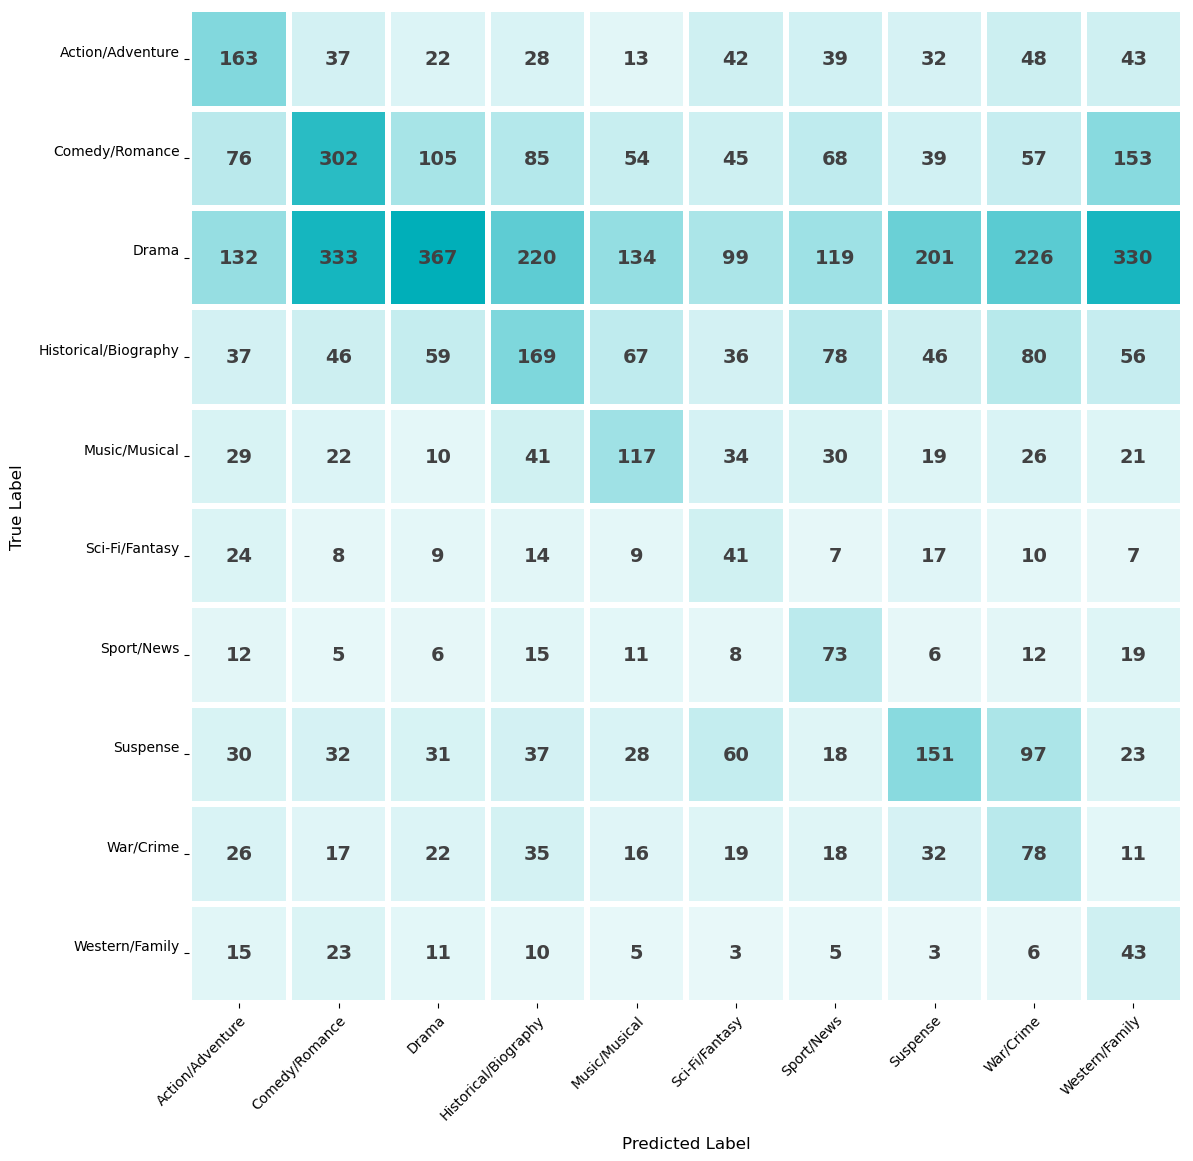

In [71]:
# Plot test confusion matrix
plot_confusion_matrix(best_model_details_svm['conf_matrix_test'], "Testing result - SVM model", original_labels)

## **2.2Logistic Regression Pipeline**

In [14]:
best_score = -np.inf
best_result_log_reg = None

# List to record results from all feature combinations
results_log_reg = []

In [ ]:
# Define hyperparameter grid for Logistic Regression.
# We tune the inverse regularization parameter "C". (Higher C means lower regularization.)
param_grid = {
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Use a stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Iterate over each feature combination
for combo_name, X_features in features_dict.items():
    print(f"\nProcessing feature combination: {combo_name}")

    # Use current feature matrix (X) and common labels (y)
    X = X_features
    y = encoded_labels

    # Split the data into training and validation sets (80/20 split) using stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    print(f"Original training set shape: {X_train.shape}, {y_train.shape}")

    # Combine X and y into a single DataFrame for easier manipulation
    train_df = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name='label')], axis=1)

    # Get the minimum class size
    min_class_size = train_df['label'].value_counts().min()
    print(f"Downsampling all classes to: {min_class_size} samples")

    # Downsample each class
    balanced_df = (
        train_df.groupby('label')
        .sample(n=min_class_size, random_state=42)
        .reset_index(drop=True)
    )

    # Split back into X and y
    X_train_bal = balanced_df.drop('label', axis=1).values
    y_train_bal = balanced_df['label'].values

    print(f"Balanced training set shape: {X_train_bal.shape}, {y_train_bal.shape}")


    # Build the pipeline: scaling -> PCA -> Logistic Regression
    # LogisticRegression is set to use multinomial loss, lbfgs solver, and balanced class weights.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('logreg', LogisticRegression(
#             multi_class='multinomial',
            solver='lbfgs',
            class_weight='balanced',
            random_state=42,
            max_iter=500
        ))
    ])

    # Set up GridSearchCV on the pipeline using the defined hyperparameter grid.
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Run hyperparameter tuning
    grid_search.fit(X_train_bal, y_train_bal)

    # Get best cross-validation score and parameters
    val_score = grid_search.best_score_
    print(f"  Best CV Score (Validation): {val_score:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

    # Evaluate training performance
    train_score = grid_search.score(X_train_bal, y_train_bal)
    print(f"  Training Score: {train_score:.4f}")

    # Evaluate the best estimator on the held-out test set
    test_score = grid_search.score(X_test, y_test)
    print(f"  Test Score: {test_score:.4f}")


    # save confusion matrices for analysis
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train_bal)
    y_pred_test = best_model.predict(X_test)


    cm_train = confusion_matrix(y_train_bal, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Classification report
    cr_train = classification_report(y_train_bal, y_pred_train, digits=2)
    cr_test = classification_report(y_test, y_pred_test, digits=2)

    result = {
        'combination': combo_name,
        'val_score': val_score,
        'train_score': train_score,
        'test_score': test_score,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'conf_matrix_train': cm_train,
        'conf_matrix_test': cm_test,
        'report_train': cr_train,
        'report_test': cr_test
    }

    # Record all results in a list
    results_log_reg.append(result)

    # Update the best model if the current validation score is higher than the best so far
    if val_score > best_score:
        best_result_log_reg = result
        best_score = val_score


Processing feature combination: HSV
Original training set shape: (23412, 96), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 96), (4960,)
  Best CV Score (Validation): 0.1738
  Best Parameters: {'logreg__C': 0.01}
  Training Score: 0.2089
  Test Score: 0.1533

Processing feature combination: HOG
Original training set shape: (23412, 3600), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 3600), (4960,)
  Best CV Score (Validation): 0.1429
  Best Parameters: {'logreg__C': 0.0001}
  Training Score: 0.3986
  Test Score: 0.1324

Processing feature combination: ResNet50
Original training set shape: (23412, 2048), (23412,)
Downsampling all classes to: 496 samples
Balanced training set shape: (4960, 2048), (4960,)
  Best CV Score (Validation): 0.2649
  Best Parameters: {'logreg__C': 0.0001}
  Training Score: 0.3829
  Test Score: 0.2274

Processing feature combination: ViT
Original training set shape: (23412, 768), (23

In [ ]:
# Save the best reglog model
best_model_details_log_reg = best_result_log_reg

with open("Features/best_logreg_model.pkl", "wb") as f:
    pickle.dump(best_result_log_reg, f)

print("\nBest Logistic Regression model details saved to 'best_logreg_model.pkl'")


Best Logistic Regression model details saved to 'best_logreg_model.pkl'


In [18]:
# Open the pickle file in read-binary mode
with open("Models/best_logreg_model.pkl", "rb") as f:
    best_model_details_logreg = pickle.load(f)

# Extract the best estimator from the loaded dictionary
best_model_logreg = best_model_details_logreg['best_estimator']

In [20]:
# (Optional) Print some details about the loaded model
print("\n===== Best LogReg Model Overall =====")
print(f"Best Combination: {best_model_details_logreg['combination']}")
print(f"Training Score: {best_model_details_logreg['train_score']:.4f}")
print(f"Validation Score: {best_model_details_logreg['val_score']:.4f}")
print(f"Test Score: {best_model_details_logreg['test_score']:.4f}")
print(f"Best Parameters: {best_model_details_logreg['best_params']}")


===== Best LogReg Model Overall =====
Best Combination: ViT+HSV
Training Score: 0.4490
Validation Score: 0.3028
Test Score: 0.2534
Best Parameters: {'logreg__C': 0.001}


In [22]:
# Print classification reports
print("\n===== Classification Report (Train) =====")
print(best_model_details_logreg['report_train'])

print("\n===== Classification Report (Test) =====")
print(best_model_details_logreg['report_test'])


===== Classification Report (Train) =====
              precision    recall  f1-score   support

           0       0.44      0.47      0.45       496
           1       0.43      0.46      0.45       496
           2       0.42      0.31      0.36       496
           3       0.46      0.43      0.45       496
           4       0.47      0.48      0.48       496
           5       0.44      0.41      0.42       496
           6       0.52      0.58      0.55       496
           7       0.44      0.48      0.46       496
           8       0.41      0.41      0.41       496
           9       0.45      0.46      0.45       496

    accuracy                           0.45      4960
   macro avg       0.45      0.45      0.45      4960
weighted avg       0.45      0.45      0.45      4960


===== Classification Report (Test) =====
              precision    recall  f1-score   support

           0       0.29      0.35      0.32       467
           1       0.39      0.31      0.34    

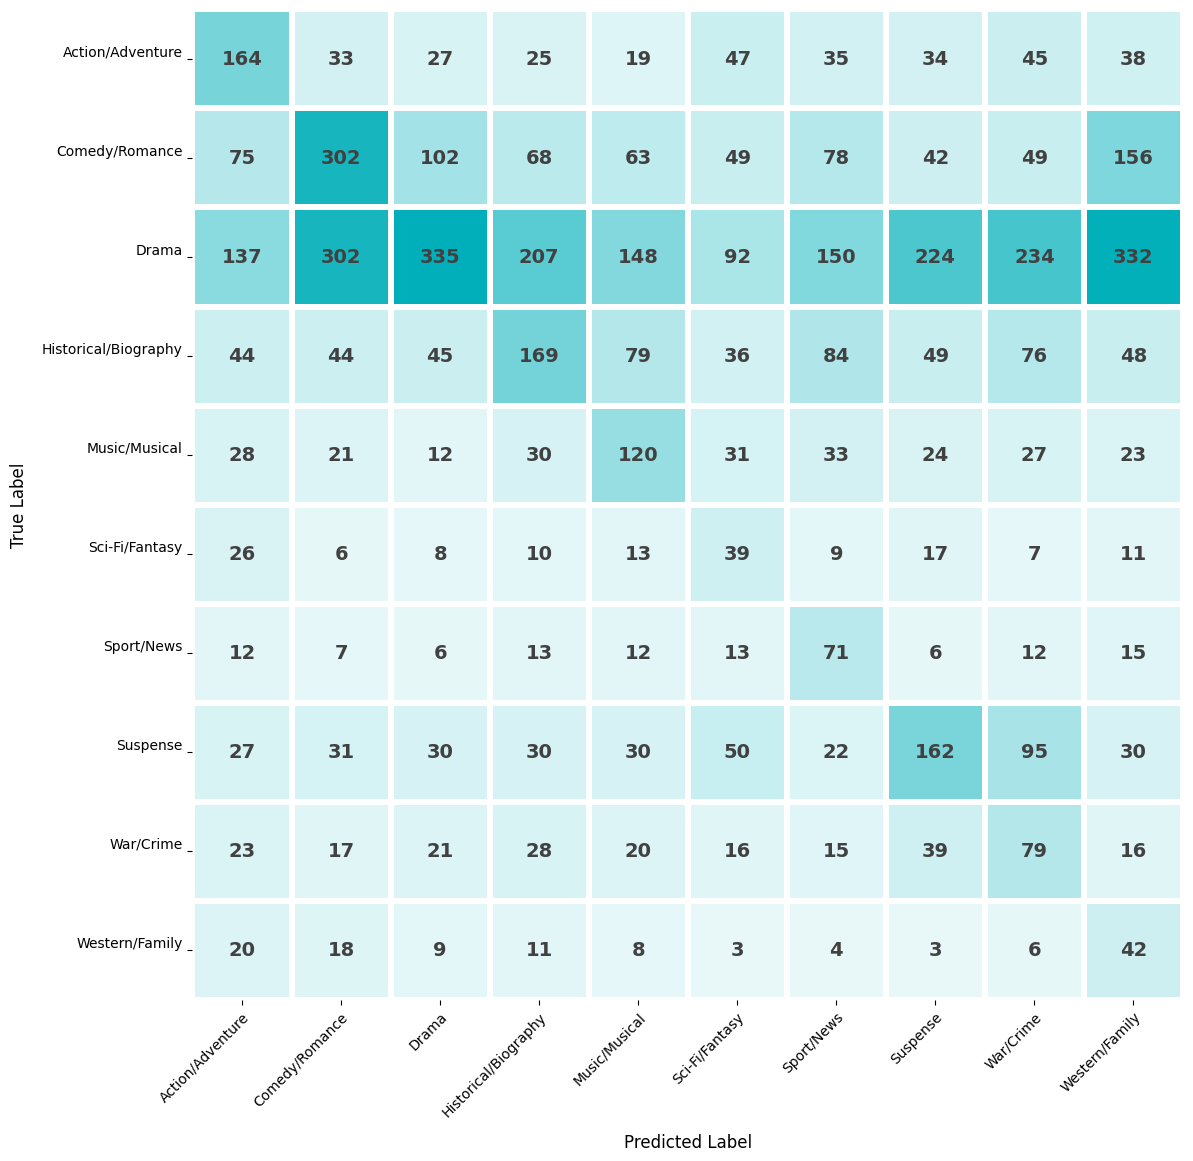

In [36]:
# Plot test confusion matrix
plot_confusion_matrix(best_model_details_logreg['conf_matrix_test'], "Confusion Matrix - Test", original_labels, 'logreg')

## **2.3 Advanced Model using CLIP for Zero-shot**

In [38]:
# Check device: use GPU if available.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [40]:
# Load the CLIP model and preprocessing pipeline.
# Here we use the "ViT-B/32" variant.
model, preprocess = clip.load("ViT-B/32", device=device)

# Load movie information from CSV.
df = pd.read_csv("movie_df_clean.csv")

# The ground-truth label is in the 'reduced_genre' column.
# Create a sorted list of the unique genres (this will serve as the classes).
unique_genres = sorted(df['reduced_genre'].unique())
print("Unique genres:", unique_genres)

# Create text prompts for zero-shot classification.
# For each genre, we generate a prompt that describes a movie poster.
text_prompts = [f"a movie poster for a {genre} film" for genre in unique_genres]

# Tokenize the text prompts (this converts them into tensors compatible with CLIP).
text_inputs = clip.tokenize(text_prompts).to(device)

# Prepare lists to store predictions and ground truth labels.
predicted_labels = []
true_labels = []

# Directory containing the movie poster images.
images_dir = os.path.join("Data", "WithText")

Unique genres: ['Action/Adventure', 'Comedy/Romance', 'Drama', 'Historical/Biography', 'Music/Musical', 'Sci-Fi/Fantasy', 'Sport/News', 'Suspense', 'War/Crime', 'Western/Family']


In [51]:
df.head()

,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type,shape,most_relevant_genre,reduced_genre
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10.0,movie,1.403333,Horror,Suspense
1,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36.0,movie,1.396667,Drama,Drama
2,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79.0,movie,1.480000,Sci-Fi,Sci-Fi/Fantasy
3,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7.0,movie,1.480000,Thriller,Suspense
4,tt10508276,Santo Domingo,2020,History,José Enrique Pintor,"Sebastian Kahuna, Víctor Daniel Gómez García, ...",The story of the foundation of the first city ...,Dominican Republic,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDYxZW...,7.9,12.0,movie,1.480000,History,Historical/Biography


In [42]:
X = df.tconst
y = df.reduced_genre

# Split the data with stratification (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [53]:
X_test.shape

(5853,)

In [54]:
y_test.value_counts()

reduced_genre
Drama                   2161
Comedy/Romance           984
Historical/Biography     674
Suspense                 507
Action/Adventure         467
Music/Musical            349
War/Crime                274
Sport/News               167
Sci-Fi/Fantasy           146
Western/Family           124
Name: count, dtype: int64

In [44]:
df_test = pd.DataFrame({
    'tconst': X_test,
    'reduced_genre': y_test
})

In [46]:
# Iterate over each row in the CSV.
for index, row in df_test.iterrows():
    
    tconst = row['tconst']
    true_label = row['reduced_genre']

    # Build the image file path (assumes images are named e.g., "tt3608918.jpg")
    image_filename = f"{tconst}.jpg"
    image_path = os.path.join(images_dir, image_filename)

    # If the image file does not exist, skip this row (or you might choose to handle differently)
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue

    # Load and preprocess the image.
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Use CLIP to compute features for the image and compare with text prompts.
    with torch.no_grad():
        # Encode image and text features
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

        # Normalize feature vectors.
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute cosine similarity between image and each text prompt.
        # The result is a vector of similarity scores.
        logits = (image_features @ text_features.T).squeeze(0)
        probs = logits.softmax(dim=0).cpu().numpy()

    # The predicted genre is the one with the highest probability.
    pred_index = np.argmax(probs)
    pred_label = unique_genres[pred_index]

    predicted_labels.append(pred_label)
    true_labels.append(true_label)

In [57]:
# # Save the final CLIP model
# torch.save(model.state_dict(), "Models/CLIP_best_clip_finetuned_model.pth")

In [48]:
# Saving predictions:
with open("CLIP_predictions.pkl", "wb") as f:
    pickle.dump((true_labels, predicted_labels), f)

# # Later, to load:
# with open("Models/CLIP_predictions.pkl", "rb") as f:
#     true_labels, predicted_labels = pickle.load(f)

In [50]:
# Evaluate the zero-shot classification performance.
print("\n=== Classification Report ===")
print(classification_report(true_labels, predicted_labels))

# Compute and print the confusion matrix.
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_genres)
print("=== Confusion Matrix ===")
print(cm)


=== Classification Report ===
                      precision    recall  f1-score   support

    Action/Adventure       0.34      0.16      0.22       467
      Comedy/Romance       0.55      0.13      0.21       984
               Drama       0.56      0.39      0.46      2161
Historical/Biography       0.32      0.29      0.30       674
       Music/Musical       0.15      0.65      0.24       349
      Sci-Fi/Fantasy       0.23      0.13      0.17       146
          Sport/News       0.23      0.56      0.33       167
            Suspense       0.24      0.38      0.29       507
           War/Crime       0.18      0.23      0.20       274
      Western/Family       0.16      0.18      0.17       124

            accuracy                           0.32      5853
           macro avg       0.30      0.31      0.26      5853
        weighted avg       0.42      0.32      0.32      5853

=== Confusion Matrix ===
[[ 75   8  69  38 126  13  51  44  27  16]
 [ 20 130 273  78 273   7  49 

In [52]:
accuracy_CLIP = accuracy_score(true_labels, predicted_labels)
print("Accuracy Score: {:.2%}".format(accuracy_CLIP))

Accuracy Score: 31.71%


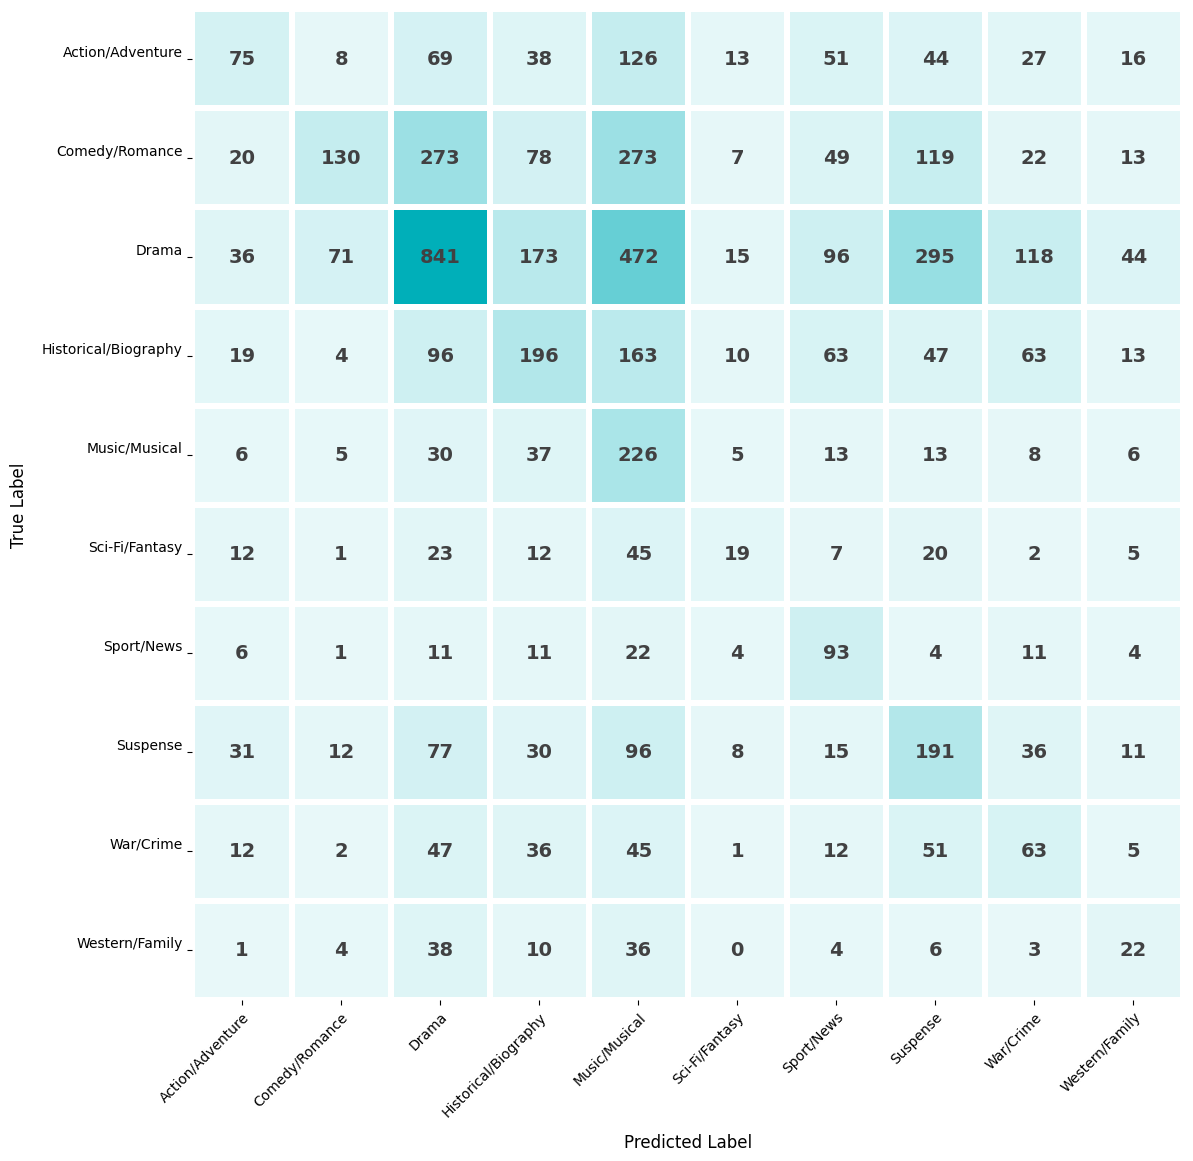

In [54]:
plot_confusion_matrix(cm, "Confusion Matrix - Test", unique_genres, "CLIP")

## **2.4 CNN (Resnet 50) with Dense Layer**

In [91]:
# Resnet Specific imports
import tensorflow as tf
tf.keras.backend.clear_session()

from tensorflow.keras import layers, models, optimizers
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
df = pd.read_csv("movie_df_clean.csv")
# We use the 'reduced_genre' column as the label.
unique_genres = sorted(df['reduced_genre'].unique())
genre_to_index = {genre: i for i, genre in enumerate(unique_genres)}
df['label'] = df['reduced_genre'].map(genre_to_index)

In [95]:
df.head()

,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type,shape,most_relevant_genre,reduced_genre,label
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10.0,movie,1.403333,Horror,Suspense,7
1,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36.0,movie,1.396667,Drama,Drama,2
2,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79.0,movie,1.480000,Sci-Fi,Sci-Fi/Fantasy,5
3,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7.0,movie,1.480000,Thriller,Suspense,7
4,tt10508276,Santo Domingo,2020,History,José Enrique Pintor,"Sebastian Kahuna, Víctor Daniel Gómez García, ...",The story of the foundation of the first city ...,Dominican Republic,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDYxZW...,7.9,12.0,movie,1.480000,History,Historical/Biography,3


In [97]:
# Set a random seed for reproducibility.
tf.random.set_seed(42)
np.random.seed(42)

# Define target size for the network (width, height)
TARGET_SIZE = (224, 224)

def resize_with_padding(image, target_size):
    """
    Resize a PIL Image while keeping its aspect ratio and pad it to the target size.

    Parameters:
        image (PIL.Image): The input image.
        target_size (tuple): Desired (width, height) output size.

    Returns:
        new_image (PIL.Image): Image resized and padded to the target size.
    """
    target_width, target_height = target_size
    original_width, original_height = image.size

    # Calculate scale factor while preserving aspect ratio.
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Use Image.Resampling.LANCZOS for high-quality downsampling.
    resized_image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)

    # Create a new image with a black background and paste the resized image centered.
    new_image = Image.new("RGB", (target_width, target_height))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image


def load_and_preprocess_image(tconst, target_size=TARGET_SIZE):
    # Use the full path to your Drive folder.
    images_dir = os.path.join("./Data/WithText/")
    image_path = os.path.join(images_dir, f"{tconst}.jpg")
    print(f"Loading image from: {image_path}")  # Debug print to verify correct path
    if not os.path.exists(image_path):
        print(f"Image for {tconst} not found at {image_path}.")
        return None
    image = Image.open(image_path).convert("RGB")
    image = resize_with_padding(image, target_size)
    img_array = img_to_array(image)
    return img_array

In [ ]:
# # UNCOMMENT if you do not have the arrays saved in your drive
# image_list = []
# label_list = []
# tconst_list = []

# for idx, row in df.iterrows():
#     tconst = row['tconst']
#     img_array = load_and_preprocess_image(tconst)
#     if img_array is None:
#         print(f"Image for {tconst} not found. Skipping...")
#         continue
#     image_list.append(img_array)
#     label_list.append(row['label'])
#     tconst_list.append(tconst)

# # Convert lists to numpy arrays.
# X = np.array(image_list)  # Shape: (n_samples, height, width, 3)
# y = np.array(label_list)

# print("Loaded images shape:", X.shape)
# print("Labels shape:", y.shape)
# print("Unique genres:", unique_genres)

# # # this cells saves the numpy arrays into drive to speed up retrieval later
# # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# # # Save arrays to Drive
# # np.save(f"/content/drive/MyDrive/datasci281-stuff/X_images_{timestamp}.npy", X)
# # np.save(f"/content/drive/MyDrive/datasci281-stuff/y_labels_{timestamp}.npy", y)
# # np.save(f"/content/drive/MyDrive/datasci281-stuff/tconst_list_{timestamp}.npy", np.array(tconst_list))

# # print(f"✅ Saved arrays at {timestamp}")
# print("X shape:", X.shape)
# print("y shape:", y.shape)
# # print("Number of tconsts:", len(tconst_list))

In [ ]:
len(image_list)

In [ ]:
# # Convert lists to numpy arrays.
# X = np.array(image_list)  # Shape: (n_samples, height, width, 3)
# y = np.array(label_list)

In [6]:

# === Step 1: Reload Preprocessed Data ===
timestamp = "20250416_012024"  # <-- Update to your saved timestamp
X = np.load(f"/content/drive/MyDrive/datasci281-stuff/X_images_{timestamp}.npy")
y = np.load(f"/content/drive/MyDrive/datasci281-stuff/y_labels_{timestamp}.npy")

# print("✅ Reloaded arrays")
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (29265, 224, 224, 3)
y shape: (29265,)


In [7]:
# plt.figure(figsize=(15, 5))
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(X[i].astype('uint8'))  # Assuming pixel values are in 0-255 range
#     plt.title(f"Image {i}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [8]:


# --------------------------------------------------
# 1. Optional: READ MOVIE CSV for metadata (like 'title', etc. if needed)
# --------------------------------------------------
CSV_PATH = "/content/drive/My Drive/datasci281-stuff/movie_df_clean.csv"
df = pd.read_csv(CSV_PATH)
print(f"CSV loaded. Rows: {len(df)}")

# Show a preview if you want
print(df.head(3))

# unique_genres can be re-derived from df
unique_genres = sorted(df["reduced_genre"].unique())
genre_to_index = {g: i for i, g in enumerate(unique_genres)}

print("Found unique genres:", unique_genres)

# --------------------------------------------------
# 2. LOAD PRE-SAVED X, y ARRAYS (FASTER)
# --------------------------------------------------
# timestamp = "20250416_012024"  # update if needed
# X = np.load(f"/content/drive/MyDrive/datasci281-stuff/X_images_{timestamp}.npy")
# y = np.load(f"/content/drive/MyDrive/datasci281-stuff/y_labels_{timestamp}.npy")

print("✅ Reloaded arrays from Drive:")
print("X shape:", X.shape)  # e.g. (29265, 224, 224, 3)
print("y shape:", y.shape)  # e.g. (29265,)

# Optionally verify shapes, or check if X, y are correct

# --------------------------------------------------
# 3. CREATE CLASS WEIGHTS FOR IMBALANCE
# --------------------------------------------------
counts = Counter(y)  # how many samples per class index
max_count = max(counts.values())

class_weight = {}
for cls_idx, count in counts.items():
    class_weight[cls_idx] = max_count / count  # scale ratio

print("Class distribution:", counts)
print("Class weights:", class_weight)

# --------------------------------------------------
# 4. TRAIN-VAL SPLIT
# --------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)
num_classes = len(np.unique(y))
print("Train set shape:", X_train.shape, y_train.shape)
print("Val set shape:", X_val.shape, y_val.shape)

# --------------------------------------------------
# 5. DEFINE + COMPILE RESNET50 MODEL
# --------------------------------------------------
TARGET_SIZE = (224, 224)

def build_resnet50_model(num_classes, trainable_base=False):
    inputs = tf.keras.Input(shape=(TARGET_SIZE[1], TARGET_SIZE[0], 3))
    # Preprocess for ResNet
    x = tf.keras.applications.resnet.preprocess_input(inputs)

    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = trainable_base

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_resnet50_model(num_classes, trainable_base=False)
model.summary()

# --------------------------------------------------
# 6. TRAIN MODEL (WITH CLASS WEIGHTS)
# --------------------------------------------------
early_stop = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,  # letss balancee
    callbacks=[early_stop],
    verbose=2
)

# --------------------------------------------------
# 7. EVALUATE + SAVE
# --------------------------------------------------
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.2%}")

model.save("/content/drive/MyDrive/datasci281-stuff/resnet50_balanced.h5")
print("✅ Model saved to Drive.")

CSV loaded. Rows: 29265
       tconst                        title  year           genre  \
0   tt3608918                    Azzurrina  2023          Horror   
1  tt28378602    Zena s gumenim rukavicama  2023           Drama   
2  tt27129223  Fast Shark II: Faster Shark  2023  Comedy, Sci-Fi   

            director                                          actors  \
0  Giacomo Franciosa  Tatiana Luter, Paolo Stella, Gianfranco Terrin   
1       Mario Sulina   Areta Curkovic, Sandra Loncaric, Miro Cabraja   
2    Chloe Pelletier  Grace Barrington, John Bradshaw, Josefa Calero   

                                                plot        country  \
0  The tale of Guendalina was passed down verball...          Italy   
1  The film was inspired by the great strike of e...        Croatia   
2  A fast shark that has grown even faster contin...  United States   

                    awards                                             poster  \
0  0 awards and 0 nominees  https://m.media-amaz

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
732/732 - 53s - 72ms/step - accuracy: 0.1663 - loss: 8.3612 - val_accuracy: 0.2038 - val_loss: 2.1449
Epoch 2/10
732/732 - 17s - 23ms/step - accuracy: 0.2148 - loss: 7.6957 - val_accuracy: 0.2225 - val_loss: 2.0926
Epoch 3/10
732/732 - 17s - 23ms/step - accuracy: 0.2367 - loss: 7.4035 - val_accuracy: 0.2209 - val_loss: 2.0920
Epoch 4/10
732/732 - 17s - 23ms/step - accuracy: 0.2549 - loss: 7.1340 - val_accuracy: 0.2313 - val_loss: 2.0648
Epoch 5/10
732/732 - 17s - 23ms/step - accuracy: 0.2724 - loss: 6.9093 - val_accuracy: 0.2416 - val_loss: 2.0428
Epoch 6/10
732/732 - 17s - 23ms/step - accuracy: 0.2852 - loss: 6.6709 - val_accuracy: 0.2361 - val_loss: 2.0468
Epoch 7/10
732/732 - 17s - 23ms/step - accuracy: 0.2989 - loss: 6.4504 - val_accuracy: 0.2570 - val_loss: 2.0051
Epoch 8/10
732/732 - 17s - 23ms/step - accuracy: 0.3130 - loss: 6.2204 - val_accuracy: 0.2455 - val_loss: 2.0220
Epoch 9/10
732/732 - 17s - 23ms/step - accuracy: 0.3314 - loss: 5.9842 - val_accuracy: 0.2469 - 

Validation Accuracy: 25.70%
✅ Model saved to Drive.


In [10]:
unique_genres = sorted(df["reduced_genre"].unique())
genre_to_index = {g: i for i, g in enumerate(unique_genres)}

original_labels = unique_genres

In [11]:
from sklearn.metrics import classification_report

# 1. (Re‑)compute predictions
y_pred_train_idx = np.argmax(model.predict(X_train), axis=1)
y_pred_val_idx   = np.argmax(model.predict(X_val),   axis=1)

# 2. Print classification reports
print("=== Classification Report: Train ===")
print(classification_report(
    y_train,
    y_pred_train_idx,
    target_names=original_labels
))

print("=== Classification Report: Validation/Test ===")
print(classification_report(
    y_val,
    y_pred_val_idx,
    target_names=original_labels
))

732/732 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
=== Classification Report: Train ===
                      precision    recall  f1-score   support

    Action/Adventure       0.39      0.43      0.41      1867
      Comedy/Romance       0.44      0.37      0.40      3936
               Drama       0.61      0.25      0.35      8642
Historical/Biography       0.36      0.31      0.33      2697
       Music/Musical       0.32      0.40      0.36      1398
      Sci-Fi/Fantasy       0.39      0.46      0.42       584
          Sport/News       0.23      0.72      0.35       669
            Suspense       0.33      0.46      0.38      2026
           War/Crime       0.18      0.56      0.28      1097
      Western/Family       0.18      0.57      0.27       496

            accuracy                           0.36     23412
           macro avg       0.34      0.45      0.36     23412
        weighted avg       0.45      0.36      0.36     23412

=== Cla

In [16]:
# 1. Define the genre order.
unique_genres = [
    "Action/Adventure", "Comedy/Romance", "Drama", "Historical/Biography",
    "Music/Musical", "Sci‑Fi/Fantasy", "Sport/News", "Suspense",
    "War/Crime", "Western/Family"
]


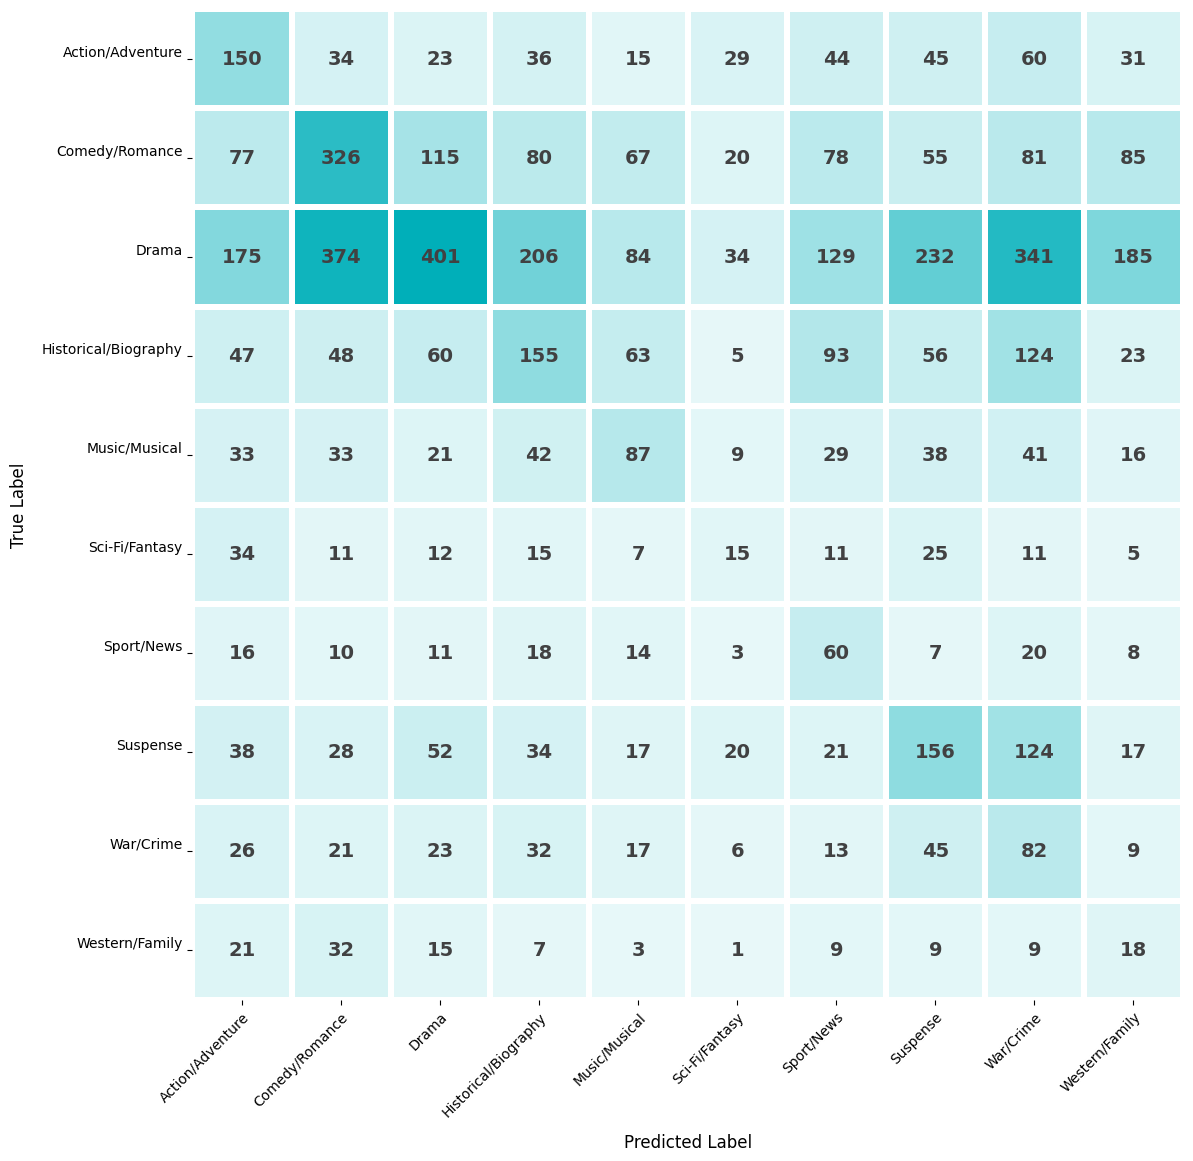

In [14]:
plot_confusion_matrix(conf_mat, "Confusion Matrix - Test", unique_genres)